In [14]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from siphon.catalog import TDSCatalog
import numpy as np
import xarray as xr

# Working with GOES Satellite Data
Satellite observations offer a wealth of information that can be enhanced when different channels are combined to generate derived products. In this notebook we'll look at how we plot satellite imagery using Python, add gamma corrections to values to make our images more human readable, and construct a true color image, which will require bringing together three different channels to compute the derived product.

The data are pulled fromt the Unidata THREDDS server https://thredds-test.unidata.ucar.edu/thredds/catalog/catalog.html

In [22]:
from datetime import datetime, UTC

# Get datetime from computer closest to now!
#date = datetime(2024, 11,13, 12)
date = datetime.utcnow()
#date = datetime.now(UTC)  #Fixes the deprecated warning (along with the UTC import above - but won't work with the 
#                           new code below!
print(date)
# Create variables for URL generation
region = 'CONUS'
channel = 2  #DRL The red channel
satellite = 'east'

2025-11-18 13:53:07.632751


/var/folders/_4/_0kls59j3ql7ypl24gs0qbk40000gp/T/ipykernel_26158/2951893561.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date = datetime.utcnow()


In [23]:
def get_satellite_data(date, region='CONUS', channel=2, satellite='east'):
    '''
    This function helps to obtain GOES satellite data by channel from the UCAR THREDDS server.
    
    Input:
      * date - a datetime object specifying the desired time
      * region - the portion of satellite data wanted
        - CONUS (default)
        - fulldisk
      * channel (int value 1 - 16; default is 2)
      * satellite ('east' or 'west'; default is 'east')
    
    Output:
      * xarray DataArray containing the nearest time requested satellite data for the region, channel, and satellite.
    '''
    # We want to match something like:
    # https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

    # Construct the data_url string
    data_url = (f'https://thredds.ucar.edu/thredds/catalog/satellite/goes/{satellite}/products/'
                f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
                f'{date:%Y%m%d}/catalog.xml')
    print(data_url)
    # Get list of files available for particular day
    cat = TDSCatalog(data_url)

    # Grab dataset for desired time
    dataset = cat.datasets.filter_time_nearest(date, regex=r'_s(?P<strptime>\d{13})', strptime='%Y%j%H%M%S')
    print(dataset)
    print(type(dataset))

    # Open most recent file available
    ds = dataset.remote_access(use_xarray=True,service='OPENDAP').metpy.parse_cf()

    filename = str(dataset)
    print(type(filename))

    return ds, filename

In [25]:
# Call function to get data closest to requested time
ds,filename = get_satellite_data(date, region, channel, satellite)

#DRL New code 11/18/2025  Shared by Unidata
n = 4  # downsampling factor
x_small = ds['Sectorized_CMI'].x[::n]
y_small = ds['Sectorized_CMI'].y[::n]
cmi_small = ds['Sectorized_CMI'][::n, ::n]

ds_small = xr.Dataset(
    coords={
        "x": x_small,
        "y": y_small,
        "time": ds.time,
    }
)

ds_small["Sectorized_CMI"] = xr.DataArray(
    cmi_small.data,
    dims=("y", "x"),
    attrs=ds["Sectorized_CMI"].attrs,
)

if "goes_imager_projection" in ds:
    ds_small["goes_imager_projection"] = ds["goes_imager_projection"]

for var in ds.data_vars:
    if var == "Sectorized_CMI":
        continue
    if ("y" in ds[var].dims) and ("x" in ds[var].dims):
        ds_small[var] = ds[var][::n, ::n]
    else:
        ds_small[var] = ds[var]

ds = ds_small

# ##### End new code

# Apply a square root correction for visible imagery only
if channel == 2:
    ds['Sectorized_CMI'].values = np.sqrt(ds['Sectorized_CMI'].values)

# specify the valid time from the file
vtime = ds.time.values.astype('datetime64[ms]').astype('O')
print(vtime)

https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/20251118/catalog.xml
OR_ABI-L2-CMIPC-M6C02_G19_s20253221346170_e20253221346170_c20253221346170.nc
<class 'siphon.catalog.Dataset'>
<class 'str'>
2025-11-18 13:46:17


In [26]:
#Takes awhile to dump! (large dataset)
ds

<xarray.Dataset> Size: 15MB
Dimensions:               (x: 2500, y: 1500)
Coordinates:
    time                  datetime64[ns] 8B 2025-11-18T13:46:17
  * x                     (x) float64 20kB -3.627e+06 -3.625e+06 ... 1.381e+06
    metpy_crs             object 8B Projection: geostationary
  * y                     (y) float64 12kB 4.589e+06 4.587e+06 ... 1.585e+06
Data variables:
    Sectorized_CMI        (y, x) float32 15MB nan nan nan ... 0.1491 0.1543
    fixedgrid_projection  int32 4B ...

### Lets do Florida Only so we don't blow the server away! 🌪️

GOES East VIS Channel 02                                                                                                                                                                                           Valid Time: 2025-11-18 13:46:17 UTC


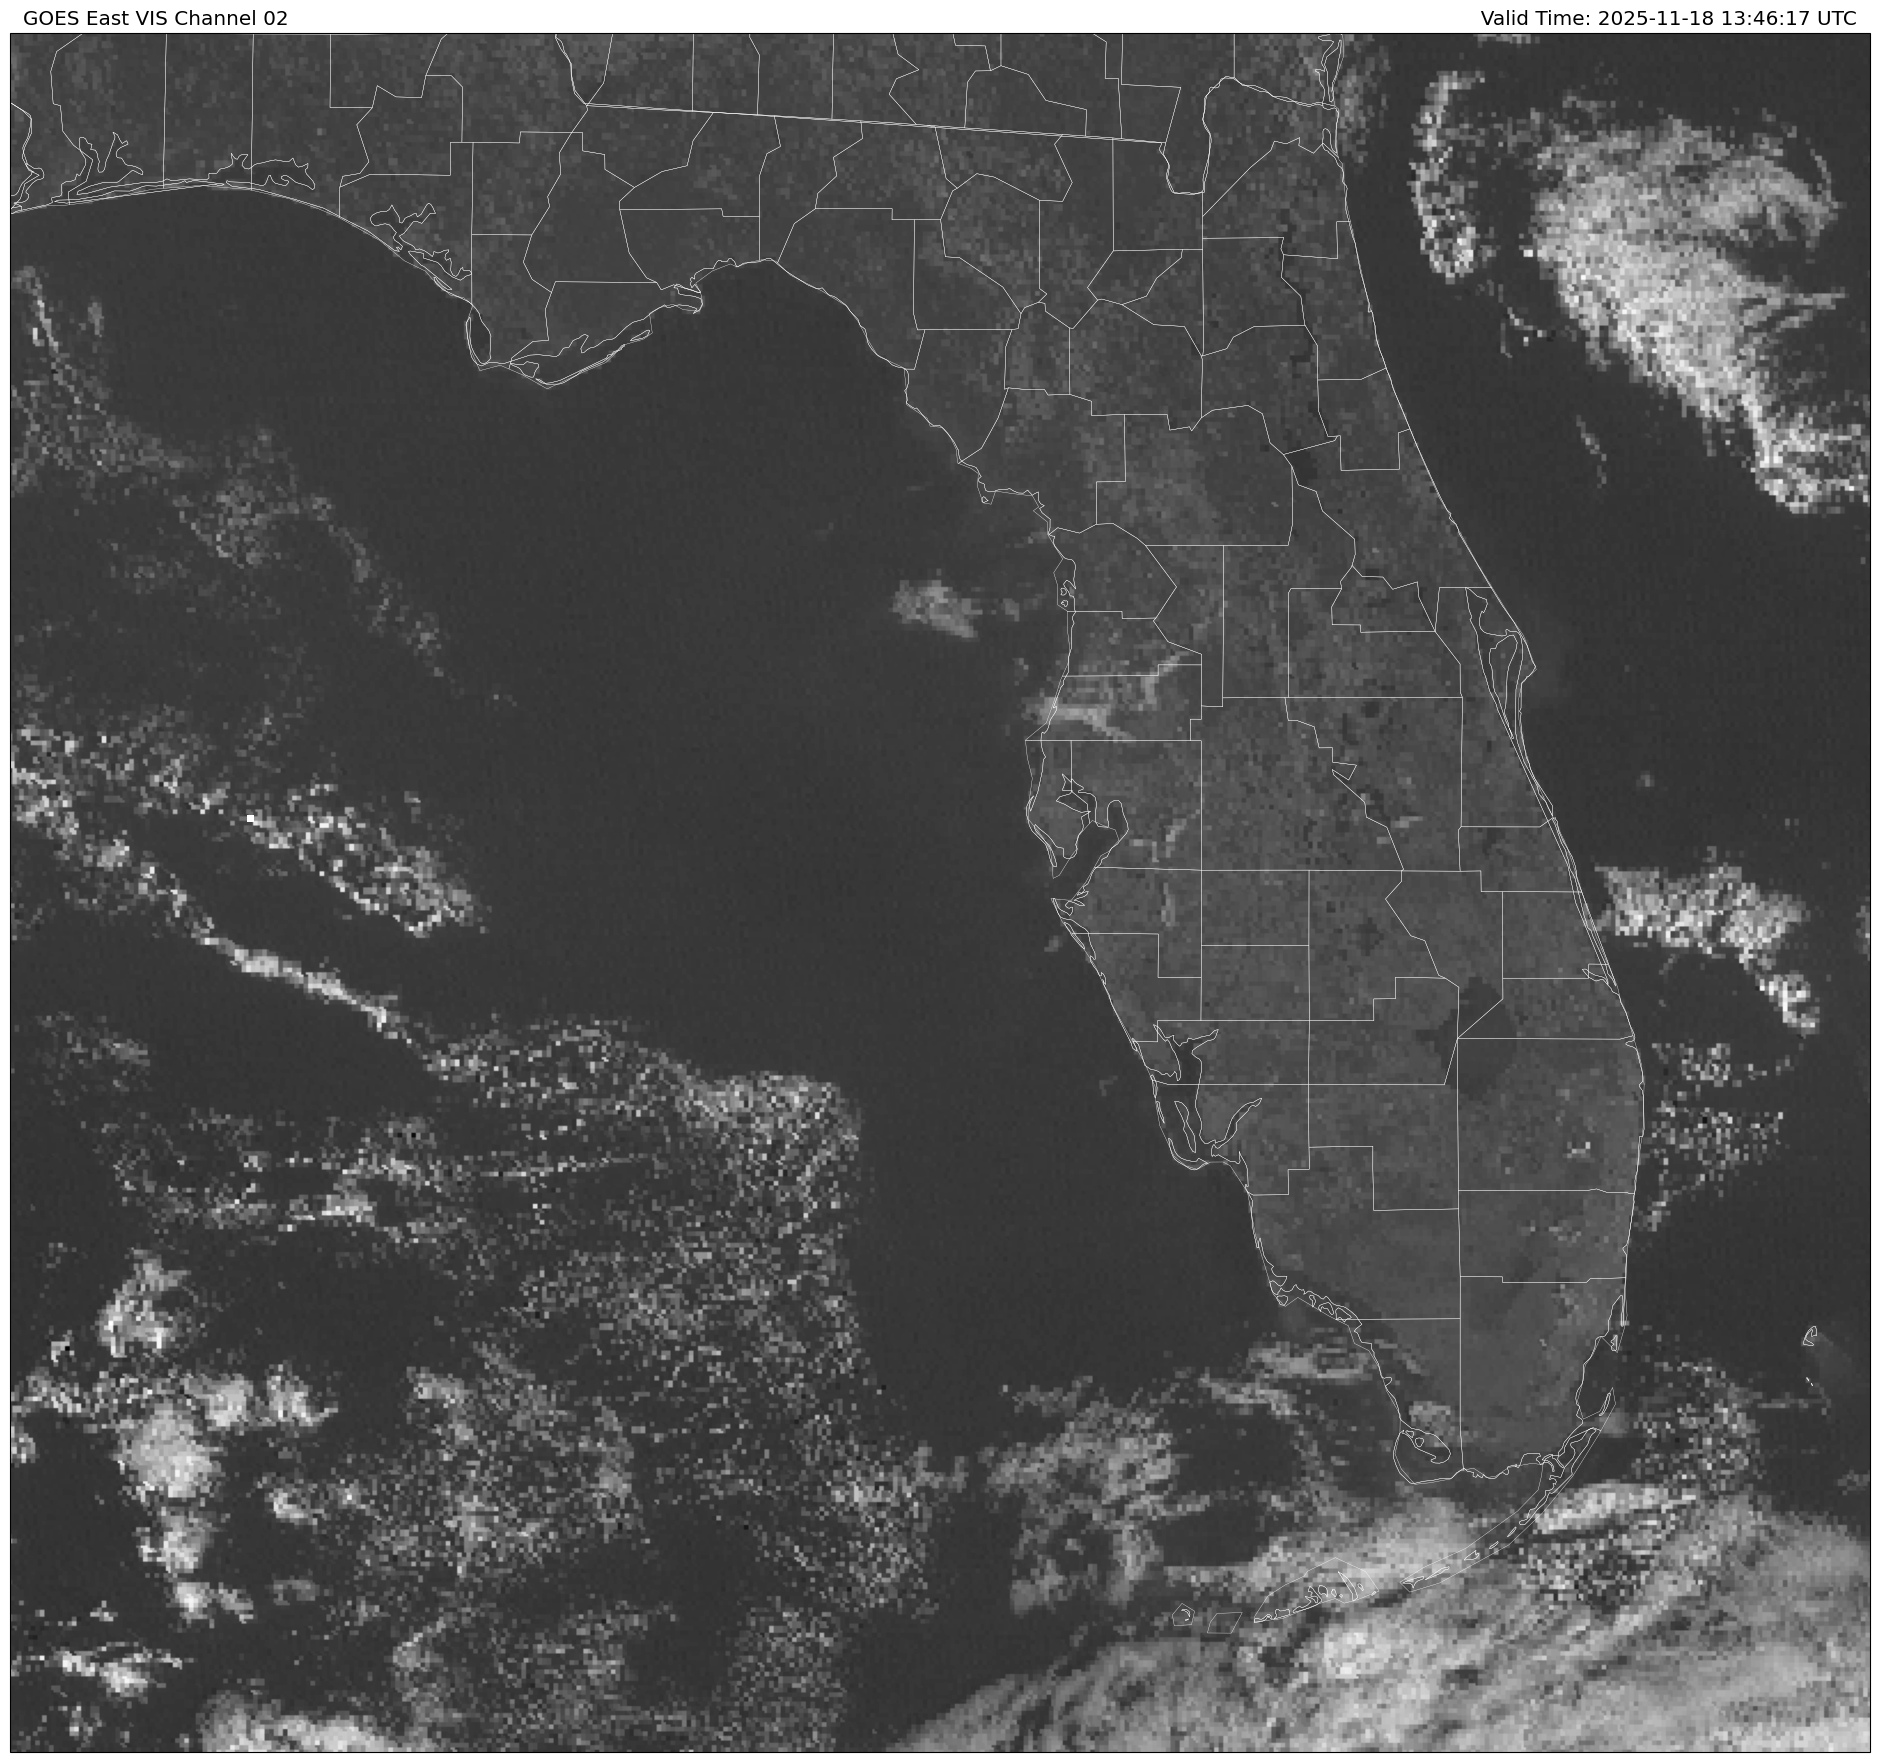

In [27]:
#DRL Code
import metpy.calc as mpcalc
from metpy.plots import ImagePlot, ContourPlot, MapPanel, PanelContainer
from metpy.units import units
#import matplotlib as plt

# Declare the imgage we wish to plot
img = ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
#img.field = 'Sectorized_CMI**(1/2.2)'
img.colormap = 'Greys_r'

# Create a figure and MapPanel
panel = MapPanel()

panel.layers = ['coastline', 'borders', 'states', 'uscounties']
panel.layers_alpha = [1.0]  #Needs MetPy V1.6 (which needs Python >=3.9)
panel.layers_edgecolor = ['white']
panel.layers_linewidth = [0.25]
panel.title = f"{f'GOES East VIS Channel {channel:02d}':<123}{f'Valid Time: {vtime} UTC':>123}"

#DRL diagnostic
print(panel.title)

#Set map panel size
#Allowed relative sizes are those of Matplotlib: ‘xx-small’, ‘x-small’, ‘small’, ‘medium’, 
#‘large’, ‘x-large’, ‘xx-large’
panel.title_fontsize = 'x-large'


#Set Projection and assign panel to the image
#panel.title(f'Valid: {vtime}', loc='right')
#There are three pre-defined projections that can be called with a short name: Lambert conformal conic (‘lcc’), Mercator (‘mer’), 
#polar-stereographic (‘ps’), or ‘area’ to use a default projection based on the string area used. Additionally, this trait can be 
#set to a Cartopy projection object. Note that the default 'area' option does not appear to work.
#panel.projection = ds.Sectorized_CMI.metpy.cartopy_crs

panel.projection = 'mer'
panel.plots = [img]

#Set Image Footprint (similar to setting extent!)

#The region (i.e., footprint) is set using area - which can be a tuple or string value. A tuple lets you set longitude/latitude box based 
#on the projection of the map (west-most, east-most, south-most, north-most). The region can also be set to a string that represents
#preset areas (see https://unidata.github.io/python-training/workshop/Satellite_Data/declarative-satellite-data/) 
#If you comment out panel.area below it will default to CONUS
#panel.area = 'fl'  (Florida footprint - see above link for other preset regions)
panel.area = -87.5, -79.0, 24.0, 31.0 #Also Florida - but a slightly smaller footprint than the one above! 

# Place the map on a figure
pc = PanelContainer()
pc.size = (24, 24)
pc.panels = [panel]
pc.show()

Original channel data have two different grid spacings. The red channel (channel 2) has data every 0.5 km, whereas the blue and veggie channels have data every 1 km. If we are going to combine these channels, we'll need to make them the same shape. The simplest method is to slice the red channel by keeping only every other data point. 

In [ ]:
# downscale red channel using every second grid point, isolate data variable
print('Original red shape:', red.Sectorized_CMI.shape)
red = red.Sectorized_CMI[::2, ::2]
veggie = veggie.Sectorized_CMI
blue = blue.Sectorized_CMI
print('New red shape:', red.shape)

In [ ]:
print('Veggie shape:',veggie.shape)